# Statistical Jump Model

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-talk')
import numpy as np
import quantbullet.research.jump_model as jm
from quantbullet import set_package_log_level, set_figsize
set_package_log_level('info')

+-------------------------+
|  Package : quantbullet  |
|  Author  : Yiming Zhang |
|  Version : 0.1.0        |
|  Note    : BETA version |
+-------------------------+


Implementation ana API of the model is all at {py:mod}`quantbullet.research.jump_model`.

## Discrete Jump Model: Basic Tutorial

Default parameters can be loaded using `TestingParams` class. This loads the same simulation inputs as the related literature. The transition matrix controls the probability of transitioning from one state to another, and the normal distribution parameters control the mean and standard deviation for each state.

In [4]:
transition_matrix, norm_params = jm.TestingUtils().daily()
print(transition_matrix)
print(norm_params)

[[0.99788413 0.00211587]
 [0.01198743 0.98801257]]
{0: (0.000615, 0.007759155881924271), 1: (-0.000785, 0.017396608864948364)}


The `SimulationGenerator` class runs the simulation by first generating the hidden states, then conditional normal returns.

Here, we observed that simulated returns indeed show pattern of volatility clustering.

09-27 21:39:53 INFO Step 1: Initial (stationary) distribution: [0.84997341 0.15002659]
09-27 21:39:54 INFO Step 2: Simulated states: Counter({0: 633, 1: 368})
09-27 21:39:54 INFO Step 3: Generate simulated return data conditional on states.


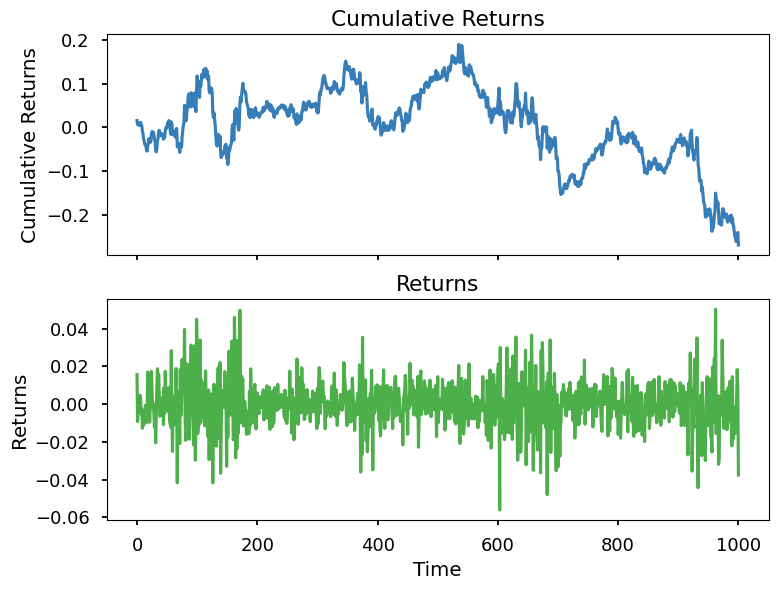

In [5]:
np.random.seed(999)
sim_states, sim_returns = jm.SimulationGenerator().run(
    steps=1000, transition_matrix=transition_matrix, norm_params=norm_params
)
jm.TestingUtils().plot_returns(sim_returns)

To fit the model, `FeatureGenerator` class enriches the features by adding a family of lagged returns and volatility features. It also standardizes the features.

In [6]:
enriched_returns = jm.FeatureGenerator().enrich_features(sim_returns)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)
enriched_returns.shape

(988, 15)

Finally, the dicrete jump model is fitted using `DiscreteJumpModel` class. Lambda is the penalty parameter for the jumps. `n_trials` is the number of trials for different initializations, as the algorithm cannot guarantee to find the global optimum. As the result shows, the model is able to uncover the simulated hidden states, except for one short period.

09-21 04:37:54 INFO Mean and Volatility by inferred states:
 {0: (0.028637970131994296, 0.7088256592365949), 1: (-0.05710237680864317, 1.4096882064420155)}


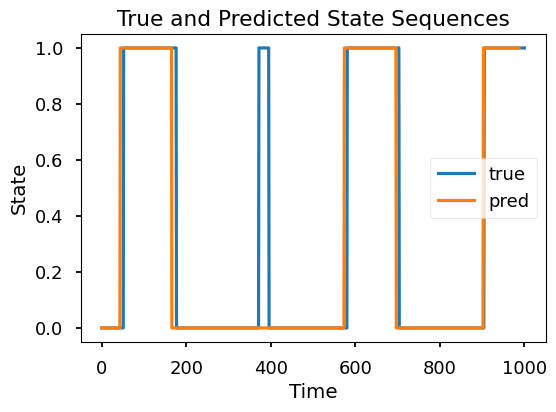

{'BAC': 0.9310483870967742}


In [5]:
model = jm.DiscreteJumpModel()
res = model.fit(enriched_returns, k=2, lambda_=100, rearrange=True, n_trials=4)
with set_figsize(6, 4):
    bac = model.evaluate(sim_states, res['best_state_sequence'], plot=True)

print(bac)

We label the identified states and plot against the returns. The model indeed captures some market downturns.

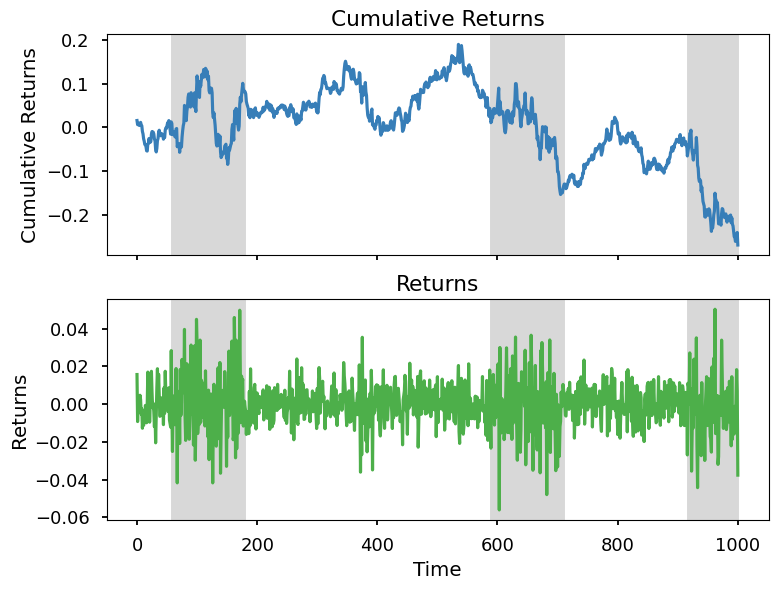

In [6]:
jm.TestingUtils().plot_returns(np.array(sim_returns), res['best_state_sequence'])

## Find the best Penalty parameter

In this section, we aim to find the best penalty parameter for the model. For each penalty parameter, we simulated 50 sequences of states with length 1000, and model runs 8 trials for each sequence. Finally, the average Balanced Accuracy is calculated for each penalty parameter.

In [7]:
from collections import defaultdict
from tqdm import tqdm
import json

bac_lambda_hist = defaultdict(list)
lambda_range = np.logspace(-2, 4, num=13, base=10)
transition_matrix, norm_params = jm.TestingUtils().daily()
model = jm.DiscreteJumpModel()

# for lambda_ in lambda_range:
#     for _ in tqdm(range(50)):
#         sim_states, sim_returns = jm.SimulationGenerator().run(steps=1000, transition_matrix=transition_matrix, norm_params=norm_params)
#         enriched_returns = jm.FeatureGenerator().enrich_features(sim_returns)
#         enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)
#         res = model.fit(enriched_returns, k=2, lambda_=lambda_, rearrange=True, n_trials=8)
#         score = model.evaluate(sim_states, res['best_state_sequence'], plot=False)
#         bac_lambda_hist[str(lambda_)].append(score["BAC"])

Below results are inline with the best penalty parameter found in the related literature.

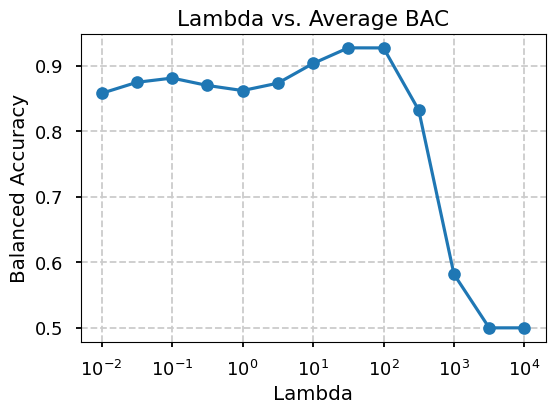

In [8]:
bac_lambda_hist = json.load(open('bac_lambda_hist.json', 'r'))
with set_figsize(6, 4):
    jm.TestingUtils().plot_averages(bac_lambda_hist)

## Continuous Jump Model

The continuous version of the jump model follows roughly the same procedure as the discrete version, but estimates a sequence of state probabilities instead of a discrete state. The algorithm is generally slower.

Here, we fit the model using the same simulated data and penalty parameter. Without bothering with many initializations and trials, we fit the model until no improvement is observed.

In [7]:
ctsJump = jm.ContinuousJumpModel()
centroids = ctsJump.initialize_kmeans_plusplus(enriched_returns, k=2)
cur_s = ctsJump.classify_data_to_states(enriched_returns, centroids)
second_col = 1 - cur_s
cur_s = np.column_stack((cur_s, second_col))

In [8]:
tol = 100
max_iter = 100
cur_loss = float('inf')
best_states = cur_s
best_loss = cur_loss
no_improvement_counter = 0  # Counter for consecutive iterations without improvement

for _ in range(max_iter):
    cur_theta = ctsJump.fixed_states_optimize(enriched_returns, cur_s, 2)  # Assuming 2 states
    lossMatrix = ctsJump.generate_loss_matrix(enriched_returns, cur_theta)
    C = ctsJump.generate_C(2)
    cur_s, cur_loss = ctsJump.fixed_theta_optimize(lossMatrix, lambda_=100, C=C)
    
    # Check if the current solution is better than the best known solution
    if cur_loss < best_loss:
        best_loss = cur_loss
        best_states = cur_s
        no_improvement_counter = 0  # Reset the counter if there's improvement
    else:
        no_improvement_counter += 1  # Increment the counter if no improvement

    # Check for convergence
    if no_improvement_counter >= 3:
        break

The model is shown to be more dynamic, and indeed captures the pattern we didn't see in the discrete version.

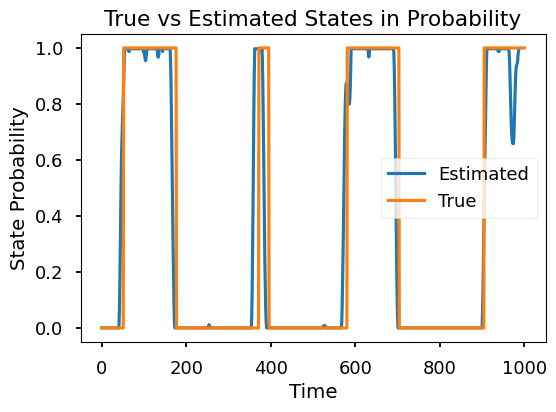

In [9]:
with set_figsize(6, 4):
    plt.plot(cur_s[:, 0], label='Estimated')
    plt.plot(sim_states, label='True')
    plt.title('True vs Estimated States in Probability')
    plt.xlabel('Time')
    plt.ylabel('State Probability')
    plt.legend()

## Working with Real Data

To work with real data, we use the daily returns of a stock, and fit the model using $\lambda=100$ as we have found.

In [5]:
import yfinance as yf
# Define the ticker symbol
ticker_symbol = "TSLA"
# Fetch data
data = yf.download(ticker_symbol, interval="1d", period="500d")

[*********************100%%**********************]  1 of 1 completed


In [6]:
log_ret = np.log(data['Adj Close'] / data['Adj Close'].shift(1)).dropna().values
enriched_returns = jm.FeatureGenerator().enrich_features(log_ret)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)

In [7]:
ctsJump = jm.ContinuousJumpModel()
best_states, best_loss = ctsJump.fit(enriched_returns, k=2, lambda_=100, n_trials=10)

Model strikes a good balance between dynamics and persistence. Almost all market downturns are captured, and the probability transitions are smooth.

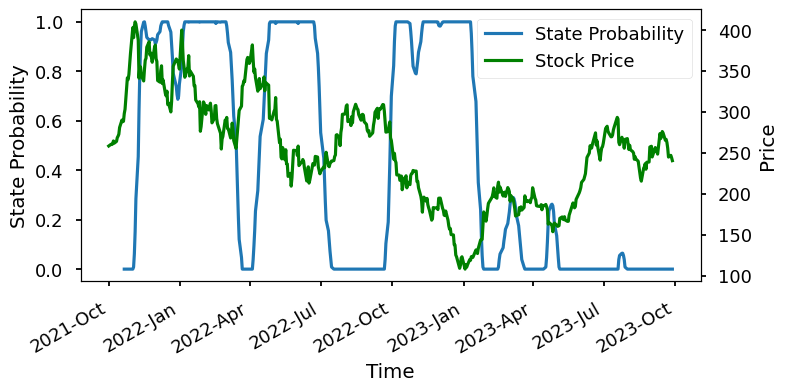

In [20]:
with set_figsize(8, 4):
    jm.TestingUtils().plot_state_probs(best_states[:, [1, 0]], data['Adj Close'])